In [1]:
!pip install -q tensorflow
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
real = '/content/drive/MyDrive/Neha Garg/Dataset Used/CASIA2/Au'
fake = '/content/drive/MyDrive/Neha Garg/Dataset Used/CASIA2/Tp'

real_path = os.listdir(real)
fake_path = os.listdir(fake)

print('Real_images :', len(real_path))
print('Fake_images :', len(fake_path))

Real_images : 7491
Fake_images : 5123


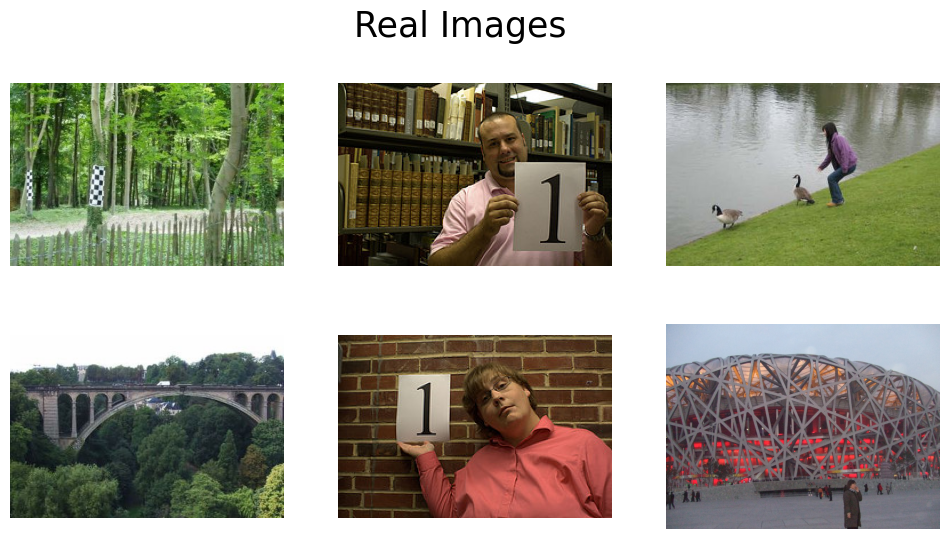

In [4]:
num_images_to_display = 6
plt.figure(figsize=(12, 6))

for i in range(num_images_to_display):
    img_path = os.path.join(real,real_path[i])
    img = Image.open(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.suptitle("Real Images",fontsize=25)
    plt.axis('off')

plt.show()

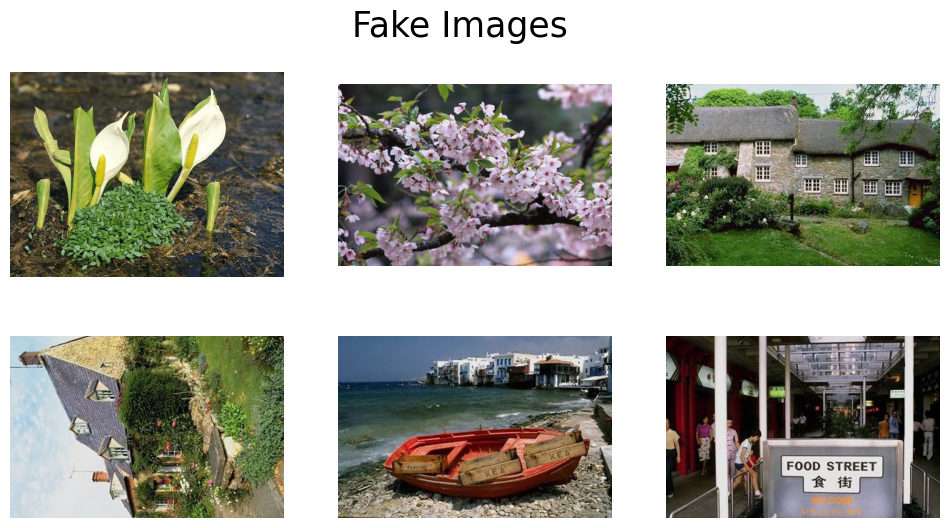

In [5]:
image_files = [file for file in fake_path if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

num_images_to_display = 6
plt.figure(figsize=(12, 6))
for i in range(num_images_to_display):
    img_path = os.path.join(fake, image_files[i])
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.suptitle("Fake Images",fontsize=25)
    plt.axis('off')

plt.show()

In [6]:
def convert_to_ela_image(path, quality):# detects inconsistencies in image compression
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


In [7]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0
X = [] # ELA converted images
Y = [] #0 for fake 1 for real

In [9]:
import random
path = '/content/drive/MyDrive/Neha Garg/Dataset Used/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tiff') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:1500]
Y = Y[:1500]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
1500 1500


In [10]:
path = '/content/drive/MyDrive/Neha Garg/Dataset Used/CASIA2/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tiff') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
3564 3564


In [11]:
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3)

#Train Test split with 80:20 ratio

# Step 1: Split into train_val (80%) and test (20%)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

# Step 2: Split train_val into train (80%) and val (20%) => overall: 64% train, 16% val
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

2280 2280
571 571


In [12]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.models import Sequential

# Define augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.05)
])


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, Multiply, Reshape, Add, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np  # Add numpy for argmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# CBAM Module
class CBAM(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel_attention = Sequential([
            GlobalAveragePooling2D(),
            Dense(input_shape[-1] // self.reduction_ratio, activation='relu'),
            Dense(input_shape[-1], activation='sigmoid')
        ])

        self.spatial_attention = Sequential([
            Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        ])

    def call(self, inputs):
        # Channel Attention
        channel_weights = self.channel_attention(inputs)
        channel_weights = Reshape((1, 1, -1))(channel_weights)
        x = Multiply()([inputs, channel_weights])

        # Spatial Attention
        spatial_weights = self.spatial_attention(x)
        x = Multiply()([x, spatial_weights])

        return x

# Updated CNN Model with CBAM
def create_cbam_cnn(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = Conv2D(32, (3,3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = CBAM()(x)  # Add CBAM Attention

    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = CBAM()(x)  # Add CBAM Again

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, x)
    return model

# Create model
model = create_cbam_cnn()

# Compile with updated loss and optimizer
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, min_lr=1e-6, verbose=1)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam (CBAM)                     │ (None, 64, 64, 32)     │         1,731 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_1 (CBAM)                   │ (None, 32, 32, 64)     │         3,717 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,121 (164.54 KB)

 Trainable params: 41,929 (163.79 KB)

 Non-trainable params: 192 (768.00 B)

In [14]:
# Train the model
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7146 - loss: 0.6172 - val_accuracy: 0.6252 - val_loss: 0.6695 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8682 - loss: 0.4472 - val_accuracy: 0.6252 - val_loss: 0.6974 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8648 - loss: 0.4420 - val_accuracy: 0.6252 - val_loss: 0.7912 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8937 - loss: 0.4200 - val_accuracy: 0.6252 - val_loss: 0.7532 - learning_rate: 1.0000e-04
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8854 - loss: 0.4120 - val_accuracy: 0.7303 - val_loss: 0.5616 - learning_rate: 1.0000e-04
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8850 - loss: 0.4240 - val_accuracy: 0.9107 - val_loss: 0.3712 - learning_rate: 1.0000e-04
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - ac

In [15]:
# Get predicted probabilities
y_pred_proba = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = Y_test.flatten()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.9243
Precision: 0.9458
Recall:    0.8704
F1 Score:  0.9066
